In [26]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [61]:
data_images = torch.load('dataset/imgs_train_val_64x64.pth')  # یا imgs_test_128x128.pth
#data_labels = torch.load('dataset/metadata.pth', weights_only=False)  # یا imgs_test_128x128.pth

with torch.serialization.safe_globals([frozenset]):
    data_labels = torch.load("dataset/metadata.pth", weights_only=True)

print(type(data_images), data_images.shape) 
print(data_labels.keys())
print(list(data_labels['img_id_to_class_id'].items())[:10])
print(list(data_labels['class_id_to_class_name'].items())[:10])

<class 'torch.Tensor'> torch.Size([8855, 3, 64, 64])
dict_keys(['img_ids', 'img_id_to_class_id', 'class_id_to_class_name', 'class_name_to_class_id', 'train_val_class_ids', 'test_class_ids', 'train_val_img_ids', 'test_img_ids', 'word_freq', 'word_id_to_word', 'word_to_word_id', 'img_id_to_encoded_caps', 'num_imgs', 'num_classes', 'num_captions_per_image', 'num_words'])
[(28488, 35), (28650, 35), (28740, 35), (28751, 35), (28312, 35), (28466, 35), (28332, 35), (28411, 35), (28441, 35), (28741, 35)]
[(1, 'Laysan_Albatross'), (2, 'Sooty_Albatross'), (4, 'Crested_Auklet'), (6, 'Parakeet_Auklet'), (9, 'Red_winged_Blackbird'), (10, 'Rusty_Blackbird'), (11, 'Yellow_headed_Blackbird'), (12, 'Bobolink'), (14, 'Lazuli_Bunting'), (15, 'Painted_Bunting')]


In [106]:
num_classes = data_labels['num_classes']
num_classes

200

In [ ]:
idx = 120
lbl_tensor = data_labels['class_id_to_class_name'][data_labels['img_id_to_class_id'][data_labels['img_ids'][idx]]]

length of images :  8855
length of image ids 8855
image id : 4345
class id : 9
class name : Red_winged_Blackbird


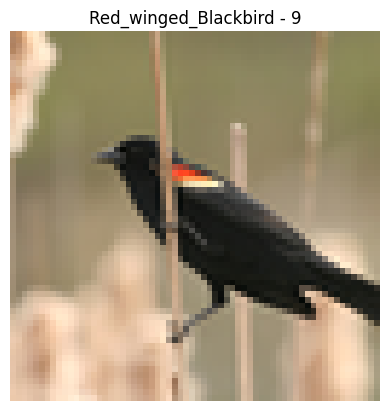

In [89]:
idx = 120

print('length of images : ',len(data_images))
print('length of image ids',len(data_labels['train_val_img_ids']))

image_id = data_labels['train_val_img_ids'][idx]
print('image id :',image_id)

class_id = data_labels['img_id_to_class_id'][image_id]
print('class id :', class_id)

class_name = data_labels['class_id_to_class_name'][class_id]
print('class name :', class_name)

img_tensor = data_images[idx]
img = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(f'{class_name} - {class_id}')
plt.axis("off")
plt.show()

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in resnet.parameters():
    param.requires_grad = False

layers =  list(resnet.children())[:-2]
model = nn.Sequential(*layers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [107]:
from torch import FloatTensor
import torch.nn.functional as F

def new_parameter(*size):
    out = nn.Parameter(FloatTensor(*size), requires_grad=True)
    torch.nn.init.xavier_normal_(out)
    return out


class Attention(nn.Module):

    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention = new_parameter(attention_size, 1)

    def forward(self, x_in):
        # after this, we have (bs, feature_size, feature_size) with a diff weight per each cell
        attention_score = torch.matmul(x_in, self.attention).squeeze()
        attention_score = F.softmax(attention_score, dim=-1).view(x_in.size(0), x_in.size(1), 1)
        scored_x = x_in * attention_score

        # now, sum across dim 1 to get the expected feature vector
        condensed_x = torch.sum(scored_x, dim=1)

        return condensed_x

In [ ]:
fmsize = 8
class Cnn_Resnet_Without_Attention(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature = model
        self.dropout = nn.Dropout(.5)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        bs = x.size()[0]

        x = self.feature(x)


In [ ]:
class Cnn_Resnet_With_Attention(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)